In [1]:
import sys
import os
from os import environ
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

from bliss.catalog import FullCatalog, TileCatalog
import tqdm

In [2]:
os.chdir('/home/taodingr/bliss/case_studies/weak_lensing/')

# Compose lensing_config_simulator.yaml
with initialize(config_path="../", version_base=None):
    cfg = compose("lensing_config_simulator")

---

Instantiate the prior and decoder:

In [16]:
prior = instantiate(cfg.prior)

decoder = instantiate(cfg.decoder)

Sample a catalog (including shear and convergence maps) from the prior and use it to generate one image:

In [17]:
# prior: p(z), z = latent variables
tile_catalog = prior.sample()

# likelihood/image model/...: p(x | z), where x = images
images, psf_params = decoder.render_images(tile_catalog)

In [18]:
tile_catalog

TileCatalog(200 x 8 x 8; galaxy_disk_frac, galaxy_beta_radians, galaxy_disk_q, galaxy_a_d, galaxy_bulge_q, galaxy_a_b, locs, n_sources, source_type, fluxes, shear_per_galaxy, shear_1_per_galaxy, shear_2_per_galaxy, shear, shear_1, shear_2, convergence_per_galaxy, convergence)

In [27]:
tile_catalog['locs'].shape

torch.Size([200, 8, 8, 200, 2])

Visualize the $\gamma_1$ map:

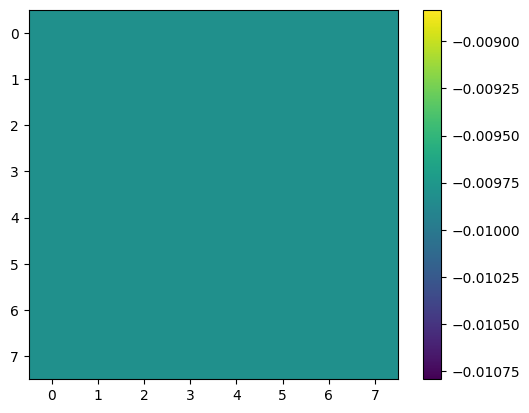

In [5]:
_ = plt.imshow(tile_catalog['shear_1'].squeeze())
_ = plt.colorbar()

Visualize the $r$-band of the image:

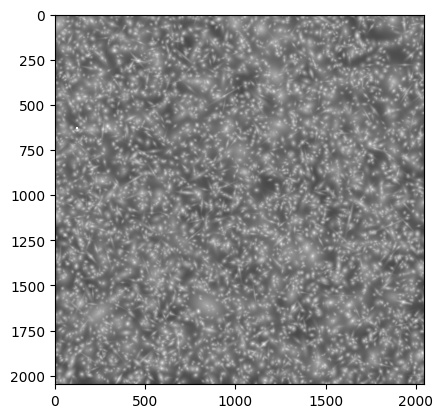

In [6]:
_ = plt.imshow((images[0][2] - images[0][2].min()).log(), cmap = 'gray')

## Import simulated image and catalog, formulationg tile catelog

In [2]:
# load simulated image and catalog dictionary
images_meta = torch.load('/data/scratch/taodingr/weak_lensing/descwl/images_meta.pt')
catalog_meta = torch.load('/data/scratch/taodingr/weak_lensing/descwl/catalog_meta.pt')

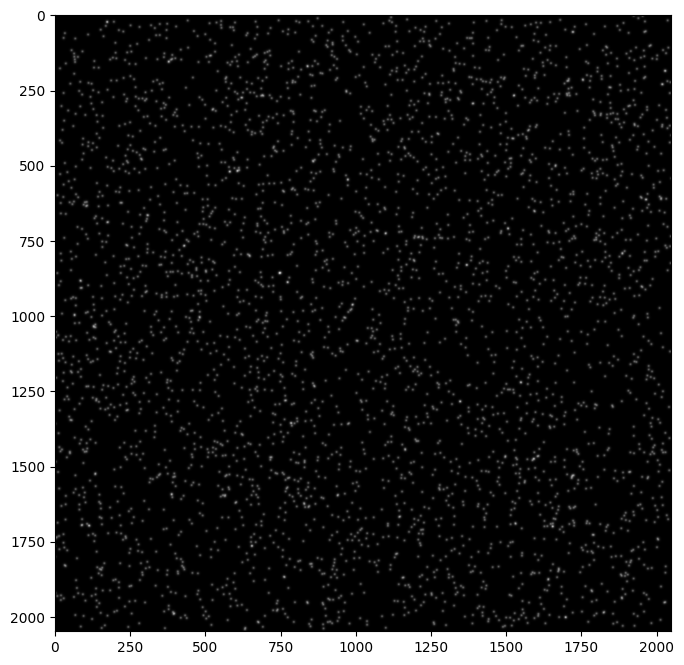

In [6]:
plt.figure(figsize=(8, 8), dpi=100)  # Larger figure with higher DPI
plt.imshow(images_meta[0][0], cmap='gray', origin='upper')
plt.show()

In [3]:
def compress_shear(shear_tensor):
    nonzero_vals = shear_tensor[shear_tensor != 0]
    unique_val = torch.unique(nonzero_vals)

    return unique_val.expand(8, 8, 1)

In [4]:
def Convert_save_images_catalogs(images, catalogs, setting="meta", shear_feature="varying"):
    """
    Convert generated catalogs to TileCatalog object and combine with generated images to form encoder input pairs;
    Then save each pair (images, TileCatalog) in a length 1 list to /data/scratch/weak_lensing/weak_lensing_img2048_setting_shear_config_shear/

    Input:
    images: 
        loaded images tensors with shape [batch_size, num_of_bands, 2048, 2048]
    catalogs: loaded catalog dictionary
        {
            "plocs": (N, num_of_sources, 2),
            "n_sources": (N, ),
            "shear_1": (N, M, 1),
            "shear_2": (N, M, 1),
        }
    settings: string
        names of the simulation settings
    shear_feature: string
        whether shear is 'constant' or 'varying'
    """
    # generate FullCatalog object
    fc = FullCatalog(2048, 2048, catalogs)

    # convert FullCatalog object to TileCatalog object
    tc = fc.to_tile_catalog(256, max_sources_per_tile=100, filter_oob=True) 

    # save path with setting names and shear features
    save_folder = f"/data/scratch/weak_lensing/weak_lensing_img2048_{setting}_{shear_feature}_shear"
    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    for idx, image in enumerate(images):
        tile_catalog = {
            'shear_1': compress_shear(tc['shear_1'][idx]),
            'shear_2': compress_shear(tc['shear_2'][idx])
        }

        dict = {
            'images': image.clone(),
            'tile_catalog': tile_catalog
        }

        torch.save([dict], f"/data/scratch/weak_lensing/weak_lensing_img2048_{setting}_{shear_feature}_shear/dataset_{idx}_size_1.pt")
    

## Check if shear 1 and shear 2 look correct

In [17]:
catalog_meta['shear_1'][3]

tensor([[-0.1089],
        [-0.1089],
        [-0.1089],
        ...,
        [-0.1089],
        [-0.1089],
        [-0.1089]])